In [1]:
import pandas as pd
import numpy as np
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt

from pprint import pprint
pd.set_option('display.width', None)
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

# Functions

In [15]:
def drop_by_index(X,indexes):
    """
    helper function to drop rows of dataframe and return new dataframe without those rows with indexes resetted
    """
    X = X.drop(indexes)
    X = X.reset_index().drop(columns="index")
    return(X)

def build_surv_obj(survival_type, years, df_dict):
    
    #Add in filter by option param logic here:
    #
    #
    #
    
    survival_type = str(survival_type)
    years = str(years)
    
    survival_df = df_dict[years + "_years"][survival_type]
    
    Time_df = survival_df.loc[:,[survival_type + "_days"]]
    Time_df[survival_type + "_years"] = Time_df[survival_type + "_days"]/365.25
    Time_df["status"] = survival_df[survival_type + "_" + years + "_years"]
    Time_df.head()

    return SurvivalData(time= (survival_type+ "_years"), status="status", data=Time_df)

def ComputeYears(df, Year_list):
    '''
    Create a list to contain df for different years of survival
    The df will filter those patient that has deceased or days of survival longer than the defined years.
    '''

    df_dict = {}

    for i in Year_list:
        tmp = {}
        for x in list(["DFS", "CSS", "OS"]):
            df['{}_{}_years'.format(x, i)] = np.where(
                                                      np.logical_or(df['death_age'] > 0,\
                                                      df['{}_days'.format(x)]/(365.25*i) >= i),\
                                                      True,False)
            tmp[x] = df[df['{}_{}_years'.format(x, i)] == True]
        df_dict['{}_years'.format(i)] = tmp
    return df_dict

def dataSetting(dropCol,FILE_FOLDER = "C:\\SMU_v2\\"):
    '''
    function to read the pkl from from datasource
        1. Remove dx_date that is NULL.
        2. Drop all rows where crucial fields for X_features are NULL.
        3. Convert Date columns into datetime format
        4. Derive OS, CSS, DFS days based on dx_date
        5. Create status column to indicate if the patient is dead or alive base on if death_age exists
    '''
    df = pd.read_pickle(FILE_FOLDER + "clinical_output.pkl").reset_index().drop(columns="index")
    to_drop = df[df['dx_date']=="NA"].index
    df = drop_by_index(df,to_drop)

    df.drop(columns=dropCol,inplace = True)

    # drop all rows where dates are null
    df.dropna(axis=0,\
                    subset=['Date_for_DFS','Date_for_OS','Date_for_CSS','dx_date','size_precise', 'nodespos'],\
                    inplace=True)

    # convert all datetime in dataframe into dateime format for processing
    df["Date_for_DFS"] = pd.to_datetime(df["Date_for_DFS"])
    df["Date_for_OS"] = pd.to_datetime(df["Date_for_OS"])
    df["Date_for_CSS"] = pd.to_datetime(df["Date_for_CSS"])
    df["dx_date"] = pd.to_datetime(df["dx_date"])
    df['last_seen']= pd.to_datetime(df["dx_date"])

    # calculate in days
    df["DFS_days"] = (df["Date_for_DFS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["OS_days"] = (df["Date_for_OS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["CSS_days"] = (df["Date_for_CSS"] - df['dx_date'] )/np.timedelta64(1, 'D')

    # alive or dead
    df['status'] = np.where(df['death_age'].isnull(), False, True)
    
    return df

### Data Processing

In [16]:
listToDrop = ['NRIC','dob','Has Bills?','Side','Hospital','KKH','NCCS','SGH',\
              'Count_as_DFS','Count_as_OS','Count_as_CSS']

clinical = dataSetting(listToDrop)

year_list = list([1,5,10])
df_dict = ComputeYears(clinical,year_list)

# Display shape of data after filtering
for i in df_dict:
    for s_type in df_dict[i]:
        print("Year: {}, survival category: {}, size: {}".format(i,s_type,df_dict[i][s_type].shape))
        

Year: 1_years, survival category: DFS, size: (14946, 212)
Year: 1_years, survival category: CSS, size: (15118, 213)
Year: 1_years, survival category: OS, size: (15118, 214)
Year: 5_years, survival category: DFS, size: (2816, 215)
Year: 5_years, survival category: CSS, size: (2867, 216)
Year: 5_years, survival category: OS, size: (2867, 217)
Year: 10_years, survival category: DFS, size: (2785, 218)
Year: 10_years, survival category: CSS, size: (2785, 219)
Year: 10_years, survival category: OS, size: (2785, 220)


In [17]:
# df_dict["10_years"]["OS"].head()

### Kaplan Meier Analysis

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

from survive import datasets
from survive import SurvivalData
from survive import KaplanMeier, Breslow, NelsonAalen

Overall Survival Modeling

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')


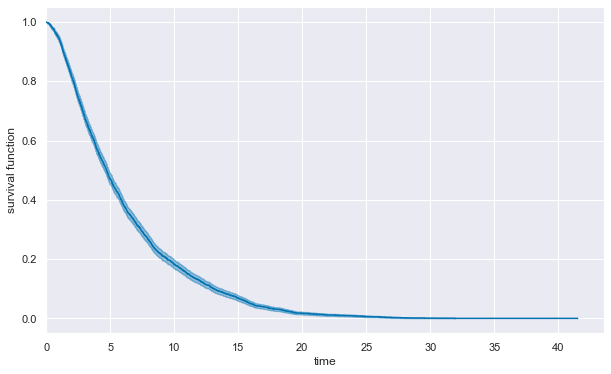

In [19]:
#Build Input DF
surv = build_surv_obj(survival_type="OS", years=10, df_dict=df_dict)
OS_km = KaplanMeier()
OS_km.fit(surv)
# print(OS_km.summary)
print(OS_km)


#Plot Curve
plt.figure(figsize=(10, 6))
OS_km.plot()
plt.show()
plt.close()

Disease Free Survival

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')


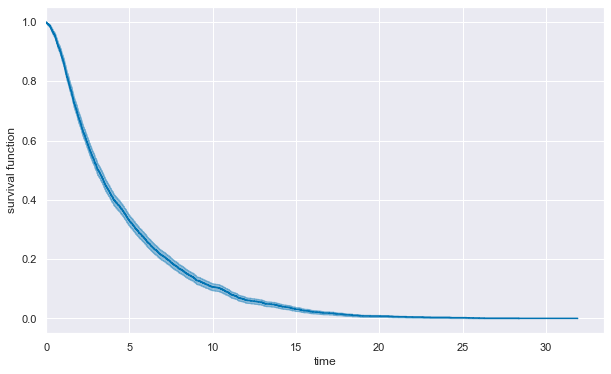

In [20]:
#Build Input DF
surv = build_surv_obj(survival_type="DFS",years=10, df_dict=df_dict)
DFS_km = KaplanMeier()
DFS_km.fit(surv)
# print(DFS_km.summary)
print(DFS_km)

#Plot curve
plt.figure(figsize=(10, 6))
DFS_km.plot()
plt.show()
plt.close()

Cancer Specific Survival

KaplanMeier(conf_level=0.95, conf_type='log-log', n_boot=500,
            random_state=None, tie_break='discrete', var_type='greenwood')


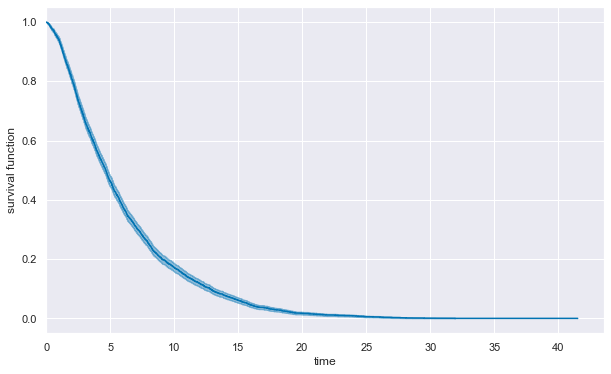

In [21]:
#Build Input DF
surv = build_surv_obj(survival_type="CSS", years=10, df_dict=df_dict)
CSS_km = KaplanMeier()
CSS_km.fit(surv)
# print(CSS_km.summary)
print(CSS_km)

#Plot curve
plt.figure(figsize=(10, 6))
CSS_km.plot()
plt.show()
plt.close()